In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from stock_pandas import StockDataFrame as SDF
from stockstats import StockDataFrame
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import LearningRateScheduler
import math

## Load Dataset - daily

In [2]:
df = pd.read_csv("../DataSets/BTC-USD.csv")
df = df.dropna()
del df['High']
del df['Low']
del df['Adj Close']
del df['Volume']
df

,Date,Open,Close
0,9/17/14,465.864014,457.334015
1,9/18/14,456.859985,424.440002
2,9/19/14,424.102997,394.795990
3,9/20/14,394.673004,408.903992
4,9/21/14,408.084991,398.821014
...,...,...,...
3135,4/18/23,29449.091800,30397.552730
3136,4/19/23,30394.187500,28822.679690
3137,4/20/23,28823.683590,28245.988280
3138,4/21/23,28249.230470,27276.910160


In [3]:
sdf = StockDataFrame.retype(df)
sdf

,open,close
date,,
9/17/14,465.864014,457.334015
9/18/14,456.859985,424.440002
9/19/14,424.102997,394.795990
9/20/14,394.673004,408.903992
9/21/14,408.084991,398.821014
...,...,...
4/18/23,29449.091800,30397.552730
4/19/23,30394.187500,28822.679690
4/20/23,28823.683590,28245.988280


In [4]:
#Check that date is the index
print(sdf.index)

Index(['9/17/14', '9/18/14', '9/19/14', '9/20/14', '9/21/14', '9/22/14',
       '9/23/14', '9/24/14', '9/25/14', '9/26/14',
       ...
       '4/13/23', '4/14/23', '4/15/23', '4/16/23', '4/17/23', '4/18/23',
       '4/19/23', '4/20/23', '4/21/23', '4/22/23'],
      dtype='object', name='date', length=3140)


## Dataset Summary

In [7]:
df_chart = df.copy()

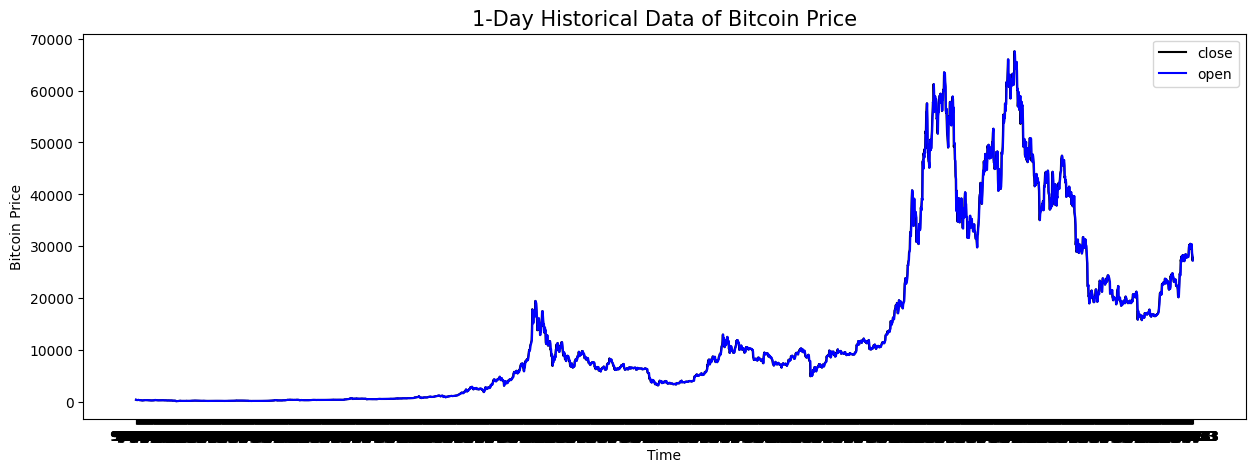

In [8]:
plt.figure(figsize=(15,5))
plt.plot(df_chart.index, df_chart['close'], color='black', label='close')
plt.plot(df_chart.index, df_chart['open'], color='blue', label='open')
plt.title('1-Day Historical Data of Bitcoin Price', fontsize=15)
plt.ylabel('Bitcoin Price')
plt.xlabel('Time')
plt.legend()

plt.show()

## Data featuring

In [9]:
feature_df = df.iloc[:,0:df.shape[1]]

scaler = MinMaxScaler(feature_range = (0,1))

scaled_features = scaler.fit_transform(feature_df.iloc[:,0:df.shape[1]-1].values)
scaled_targets = scaler.fit_transform(feature_df.iloc[:,df.shape[1]-1:df.shape[1]].values)

df_ft = pd.DataFrame(columns=feature_df.columns[0:df.shape[1]-1],
                         data=scaled_features,
                         index=feature_df.index)

df_y = pd.DataFrame(columns=feature_df.columns[df.shape[1]-1:df.shape[1]],
                         data=scaled_targets,
                         index=feature_df.index)

In [10]:
df_ft

,open
date,
9/17/14,0.004289
9/18/14,0.004155
9/19/14,0.003669
9/20/14,0.003232
9/21/14,0.003431
...,...
4/18/23,0.434481
4/19/23,0.448509
4/20/23,0.425198


In [11]:
df_y

,close
date,
9/17/14,0.004144
9/18/14,0.003655
9/19/14,0.003216
9/20/14,0.003425
9/21/14,0.003275
...,...
4/18/23,0.448435
4/19/23,0.425065
4/20/23,0.416507


In [12]:
def lstm_split(data, target, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps + 1):
        X.append(data[i:i + n_steps, 0:df.shape[1]-1])
        y.append(target[i:i+1, -1])
    return np.array(X), np.array(y)

def lstm_split2(data, n_steps):
    X = []
    for i in range(len(data) - n_steps + 1):
        X.append(data[i:i + n_steps, 0:df2.shape[1]-1])
    return np.array(X)

In [13]:
n_steps = 100
X1, y1 = lstm_split(df_ft.values, df_y.values, n_steps)

In [14]:
print(X1.shape, y1.shape)

(3041, 100, 1) (3041, 1)


In [15]:
X_train, X_test, y_train, y_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

In [16]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(2128, 100, 1) (2128, 1) (913, 100, 1) (913, 1)


## LSTM model

In [17]:
model = Sequential ()
model. add(LSTM(units = 100, return_sequences= True, input_shape = (X_train.shape[1], X_train.shape[2])))
model. add (Dropout (0.2))
model. add (LSTM(units = 50, return_sequences= True))
model. add (Dropout (0.2))
model. add(LSTM(units = 100, return_sequences= True))
model. add(Dropout (0.2))
model.add(LSTM(units = 50))
model.add(Dropout (0.2))
model.add(Dense (units=1))

model.compile(optimizer='adam', loss='mean_squared_error')

Metal device set to: Apple M2


## model Summary

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 100)          40800     
                                                                 
 dropout (Dropout)           (None, 100, 100)          0         
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           30200     
                                                                 
 dropout_1 (Dropout)         (None, 100, 50)           0         
                                                                 
 lstm_2 (LSTM)               (None, 100, 100)          60400     
                                                                 
 dropout_2 (Dropout)         (None, 100, 100)          0         
                                                                 
 lstm_3 (LSTM)               (None, 50)                3

In [19]:
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50


2023-04-23 19:01:53.031256: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


67/67 [==============================] - 6s 41ms/step - loss: 0.0155
Epoch 2/50
67/67 [==============================] - 2s 36ms/step - loss: 0.0080
Epoch 3/50
67/67 [==============================] - 3s 37ms/step - loss: 0.0091
Epoch 4/50
67/67 [==============================] - 3s 38ms/step - loss: 0.0065
Epoch 5/50
67/67 [==============================] - 3s 38ms/step - loss: 0.0057
Epoch 6/50
67/67 [==============================] - 3s 52ms/step - loss: 0.0056
Epoch 7/50
67/67 [==============================] - 3s 50ms/step - loss: 0.0056
Epoch 8/50
67/67 [==============================] - 3s 46ms/step - loss: 0.0047
Epoch 9/50
67/67 [==============================] - 4s 61ms/step - loss: 0.0044
Epoch 10/50
67/67 [==============================] - 3s 51ms/step - loss: 0.0036
Epoch 11/50
67/67 [==============================] - 3s 39ms/step - loss: 0.0026
Epoch 12/50
67/67 [==============================] - 3s 39ms/step - loss: 0.0026
Epoch 13/50
67/67 [=============================

## Evaluate

In [20]:
y_pred = model.predict(X_test)

29/29 [==============================] - 2s 16ms/step


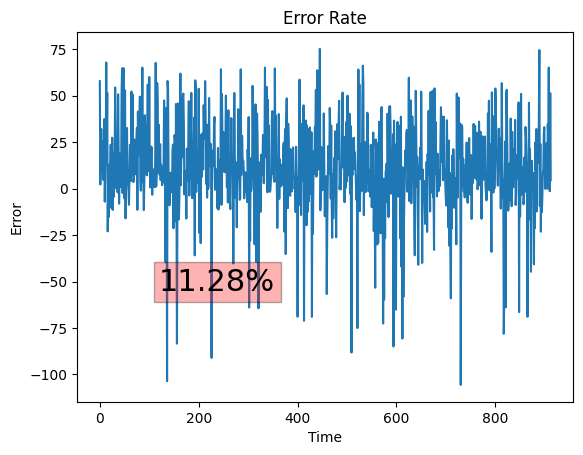

In [21]:
error_rates = (y_test.reshape(-1, 1) - y_pred) / y_test.reshape(-1, 1) * 100
average_error_rate = np.sum(error_rates)/len(error_rates)
plt.plot(error_rates)
plt.text(120,-55, f'{average_error_rate:.2f}%', fontsize = 22, bbox = dict(facecolor = 'red', alpha = 0.3))
plt.title('Error Rate')
plt.xlabel('Time')
plt.ylabel('Error')
plt.show()

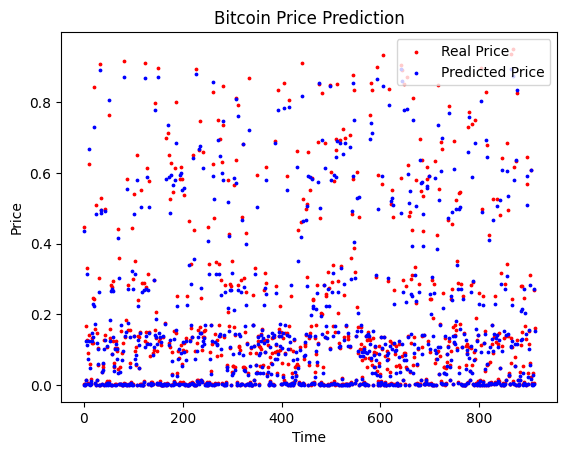

In [22]:
y_test_index = range(len(y_test))

y_test_series = pd.Series(y_test.reshape(-1,), index=y_test_index)
y_pred_series = pd.Series(y_pred.reshape(-1,), index=y_test_index)

plt.scatter(y_test_series.index, y_test_series, color='red', label='Real Price', s=3)
plt.scatter(y_pred_series.index, y_pred_series, color='blue', label='Predicted Price', s=3)
plt.title('Bitcoin Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

## Predicting Today's closing price
## To predict today's price, you need to download the n_step previous data

In [42]:
df2 = pd.read_csv("../DataSets/BTC-USD2.csv")
df2 = df2.dropna()
del df2['High']
del df2['Low']
del df2['Adj Close']
del df2['Volume']

In [43]:
df2

,Date,Open,Close
0,2023-01-13,18868.906250,19909.574219
1,2023-01-14,19910.537109,20976.298828
2,2023-01-15,20977.484375,20880.798828
3,2023-01-16,20882.224609,21169.632813
4,2023-01-17,21175.833984,21161.519531
...,...,...,...
95,2023-04-18,29449.091797,30397.552734
96,2023-04-19,30394.187500,28822.679688
97,2023-04-20,28823.683594,28245.988281
98,2023-04-21,28249.230469,27276.910156


In [44]:
Open = 27804.27
TODAY = pd.DataFrame({'Date': ['2023-04-23'], 
                            'Open': [Open], 
                            'Close': [np.nan]})

In [45]:
TODAY

,Date,Open,Close
0,2023-04-23,27804.27,NaN


In [46]:
df2 = pd.concat([df2, TODAY], ignore_index=True)

In [47]:
sdf2 = StockDataFrame.retype(df2)
sdf2

,open,close
date,,
2023-01-13,18868.906250,19909.574219
2023-01-14,19910.537109,20976.298828
2023-01-15,20977.484375,20880.798828
2023-01-16,20882.224609,21169.632813
2023-01-17,21175.833984,21161.519531
...,...,...
2023-04-19,30394.187500,28822.679688
2023-04-20,28823.683594,28245.988281
2023-04-21,28249.230469,27276.910156


In [48]:
df2.shape[0]

101

In [49]:
df2 = df2.iloc[1:df2.shape[0],:]
df2

,open,close
date,,
2023-01-14,19910.537109,20976.298828
2023-01-15,20977.484375,20880.798828
2023-01-16,20882.224609,21169.632813
2023-01-17,21175.833984,21161.519531
2023-01-18,21161.050781,20688.781250
...,...,...
2023-04-19,30394.187500,28822.679688
2023-04-20,28823.683594,28245.988281
2023-04-21,28249.230469,27276.910156


In [50]:
feature_df2 = df2.iloc[:,0:df2.shape[1]]

scaler = MinMaxScaler(feature_range = (0,1))

scaled_features2 = scaler.fit_transform(feature_df2.iloc[:,0:df2.shape[1]-1].values)
scaled_targets2 = scaler.fit_transform(feature_df2.iloc[:,df2.shape[1]-1:df2.shape[1]].values)

df_ft2 = pd.DataFrame(columns=feature_df2.columns[0:df2.shape[1]-1],
                         data=scaled_features2,
                         index=feature_df2.index)

df_y2 = pd.DataFrame(columns=feature_df2.columns[df2.shape[1]-1:df2.shape[1]],
                         data=scaled_targets2,
                         index=feature_df2.index)

In [51]:
df_ft2 = df_ft2.dropna()
df_ft2

,open
date,
2023-01-14,0.000000
2023-01-15,0.100844
2023-01-16,0.091840
2023-01-17,0.119591
2023-01-18,0.118194
...,...
2023-04-19,0.990873
2023-04-20,0.842435
2023-04-21,0.788140


In [52]:
X2 = lstm_split2(df_ft2.values, n_steps)

In [53]:
X2.shape

(1, 100, 1)

In [54]:
y_today = model.predict(X2)

1/1 [==============================] - 0s 108ms/step


In [55]:
y_today.shape

(1, 1)

In [56]:
y_today_original = scaler.inverse_transform(y_today)

In [57]:
y_today_original

array([[22359.916]], dtype=float32)

In [58]:
Today = y_today_original.astype(np.float32)

## Fee calculating
based on biance trading fees(0.1%)

In [59]:
buying_fee = Open * 0.001
selling_fee = Today * 0.001
fees = buying_fee + selling_fee
if (Open > Today + fees):
    print("stay")
elif (Open > Today + fees):
    print("You can earn money today: ", ((Today + fees)-Open)/Open*100, "%")

stay
